<a href="https://colab.research.google.com/github/Philliec459/Open-Source-Petrophysics/blob/main/NMR_Echo_Train_Simple_T2_Inversion_Example/Tutorial-curve_fit_echo_train_using_phase_rotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
using_colab = True

In [2]:
if using_colab:

    !wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/NMR_Echo_Train_Simple_T2_Inversion_Example/radians.gif'
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/STELLA_brief_ver2_backyard_grass_shoreline.ipynb
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_grass_shade_whiteshade.xlsx
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_FullSun.xlsx

    !pip install scipy

--2024-12-31 19:50:54--  https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/NMR_Echo_Train_Simple_T2_Inversion_Example/radians.gif
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Philliec459/Open-Source-Petrophysics/main/NMR_Echo_Train_Simple_T2_Inversion_Example/radians.gif [following]
--2024-12-31 19:50:54--  https://raw.githubusercontent.com/Philliec459/Open-Source-Petrophysics/main/NMR_Echo_Train_Simple_T2_Inversion_Example/radians.gif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63073 (62K) [image/gif]
Saving to: ‘radians.gif’

radians.gif         100%[===================>]

---

### **The Fascinating Process of NMR Log Processing**

NMR logging is a fascinating subject (at least to me). I find it intriguing how we can go from time-domain echo trains (with noise!) and, through T2 inversion, create T2 distributions that we can partition into useful volumes: **Clay Bound Water (CBW)**, **Bound Volume Irreducible (BVI)**, and **Free Fluid Index (FFI)**.

An NMR log almost paints a picture of the reservoir. For example, the **FFI pore volume** is typically displayed in yellow, while the **BVI pore volume** is shown in dark blue. The more yellow you see, the better the rock quality, transmissibility, and storage capacity. This simple presentation says so much about the rock.

To better understand the process and test inversion methods, we created MRIL-type NMR logging echoes from eight bin porosities ranging from 4 ms to 512 ms. The organization of this post closely follows ideas shared by **Dr. Ridvan Akkurt** in an email we exchanged from over a year ago as we discussed these concepts. I didn’t move forward until I found a graceful way to split the noise train, which had been a sticking point for me. Ridvan’s approach was very logical, and I basically followed his flow, but I was initially hung up on how to create and apply a noise channel twice the length of the echo train. While working on another project, it all finally clicked, and I was able to finish this code.

```python
a = [1,2,3,4,5,6]
print('our array:', a)
print('a[:3] =', a[:3])
print('a[3:] =', a[3:])
```
    our array: [1, 2, 3, 4, 5, 6]
    a[:3] = [1, 2, 3]
    a[3:] = [4, 5, 6]


The following function generates the synthetic echo train:

```python
def func(x, p1, p2, p3, p4, p5, p6, p7, p8):
    return (p1 * np.exp(-x / 4) +
            p2 * np.exp(-x / 8) +
            p3 * np.exp(-x / 16) +
            p4 * np.exp(-x / 32) +
            p5 * np.exp(-x / 64) +
            p6 * np.exp(-x / 128) +
            p7 * np.exp(-x / 256) +
            p8 * np.exp(-x / 512))
```

We create an echo train with **300 echoes** and a TE of **1.2 ms**. A phase angle of **45° (π/4 radians)** is applied:

```python
# Create x array for the echo train
num_echoes = 300
TE = 1.2  # Echo spacing (ms)
xdata = np.arange(num_echoes) * TE
phase_angle = np.pi / 4  # Phase angle in radians

# Generate the echo train
y = func(xdata, P1, P2, P3, P4, P5, P6, P7, P8)
```

Next, we add random noise to the echo trains by first creating a noise train twice the length of each echo train:

```python
# Create a noise train
noise_train = np.random.normal(0, noise_level, size=num_echoes * 2)
```

We then rotate the signal to create real and imaginary components:

```python
# Rotate the signal
rotated_real = y * np.cos(phase_angle)
rotated_imag = y * np.sin(phase_angle)
```

Half of the noise is added to the **real channel**, and the other half is added to the **imaginary channel**:

```python
# Add noise to the real and imaginary channels
real_channel_with_noise = rotated_real + noise_train[:num_echoes]
imag_channel_with_noise = rotated_imag + noise_train[num_echoes:]
```

Finally, we phase-correct the noisy real and imaginary channels to recover the original signal in the real channel and isolate the noise in the imaginary channel:

```python
# Phase correction
echo_train_real = (real_channel_with_noise * np.cos(phase_angle) +
                   imag_channel_with_noise * np.sin(phase_angle))
echo_train_imag = (-real_channel_with_noise * np.sin(phase_angle) +
                   imag_channel_with_noise * np.cos(phase_angle))
```

The fun begins now! Since the noise in this example is **2 pu of random Gaussian noise**, we reduce the noise in the real echo train by **stacking** (averaging echoes across three depth levels) before performing the T2 inversion.

For the inversion, we use the Python SciPy library and apply a least-squares method:

```python
# Least-squares objective function
def objective(p, x, y, alpha):
    y_pred = func(x, *p)
    error = y - y_pred
    return np.concatenate([error, np.sqrt(alpha) * p])

result = least_squares(objective, p0, args=(xdata, ystack, alpha), bounds=([0]*8, [20]*8))
popt = result.x
```


### **Closing Thoughts**

NMR logging is not only a powerful tool but also a fascinating process to study and replicate. The ability to process raw echo trains, apply phase rotation, stack the data, and invert for T2 distributions opens a window into the reservoir. Whether for reservoir characterization or testing inversion methods, the steps outlined above can help practitioners understand and optimize their workflows.


Feel free to share your thoughts or questions in the comments below!

## Import Python libraries:

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  8 12:33:54 2020

@author: craig
"""
%matplotlib inline
#%matplotlib tk

#from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# **Tutorial on the Phase Correction of the X and Y channels with noise**

NMR logging is a fascinating subject (at least to me). I find it intriguing how we can go from time-domain echo trains (with noise!) and, through T2 inversion, create T2 distributions that we can partition into useful volumes: **Clay Bound Water (CBW)**, **Bound Volume Irreducible (BVI)**, and **Free Fluid Index (FFI)**.

An NMR log almost paints a picture of the reservoir. For example, the **FFI pore volume** is typically displayed in yellow, while the **BVI pore volume** is shown in dark blue. The more yellow you see, the better the rock quality, transmissibility, and storage capacity. This simple presentation says so much about the rock.

To better understand the process and test inversion methods, we created MRIL-type NMR logging echoes from eight bin porosities ranging from 4 ms to 512 ms. The following function generates the synthetic echo train:

```python
def func(x, p1, p2, p3, p4, p5, p6, p7, p8):
    return (p1 * np.exp(-x / 4) +
            p2 * np.exp(-x / 8) +
            p3 * np.exp(-x / 16) +
            p4 * np.exp(-x / 32) +
            p5 * np.exp(-x / 64) +
            p6 * np.exp(-x / 128) +
            p7 * np.exp(-x / 256) +
            p8 * np.exp(-x / 512))
```

We create an echo train with **300 echoes** and a TE of **1.2 ms**. A phase angle of **30° (π/6 radians)** is applied:

```python
# Create x array for the echo train
num_echoes = 300
TE = 1.2  # Echo spacing (ms)
xdata = np.arange(num_echoes) * TE
phase_angle = np.pi / 4  # Phase angle in radians

# Generate the echo train
y = func(xdata, P1, P2, P3, P4, P5, P6, P7, P8)

```

We then rotate the signal to create real and imaginary components:

```python
# Rotate the signal
rotated_real = y * np.cos(phase_angle)
rotated_imag = y * np.sin(phase_angle)
```

### [We are using phase angles in radians](https://en.wikipedia.org/wiki/Radian)
    
![Geolog](https://github.com/Philliec459/Open-Source-Petrophysics/blob/main/NMR_Echo_Train_Simple_T2_Inversion_Example/radians.gif?raw=1)  

#### Choose the phase angle that you want to use:

    phase_angle = np.pi/2 sets the variable phase_angle to the value of pi/2,
    which is approximately 1.5707963267948966 radians or 90 degrees.

    phase_angle = np.pi/4 sets the variable phase_angle to the value of pi/4,
    which is approximately 0.7853981633974483 radians or 45 degrees.

    phase_angle = np.pi/6 sets the variable phase_angle to the value of pi/6,
    which is approximately 0.5235987755982988 radians or 30 degrees.

    phase_angle = np.pi/8 sets the variable phase_angle to the value of pi/8,
    which is approximately 0.39269908169872414 radians or 22.5 degrees.

```python
'''Enter the phase anlge in radians'''
# Choose a phase angle
phase_angle_rad = np.pi/6
print('phase_angle_rad =',round(phase_angle_rad, 2))
phase_angle_deg = np.rad2deg(phase_angle_rad)
print('phase_angle_deg =',round(phase_angle_deg, 2))
print()
```

    phase_angle_rad = 0.52
    phase_angle_deg = 30.0



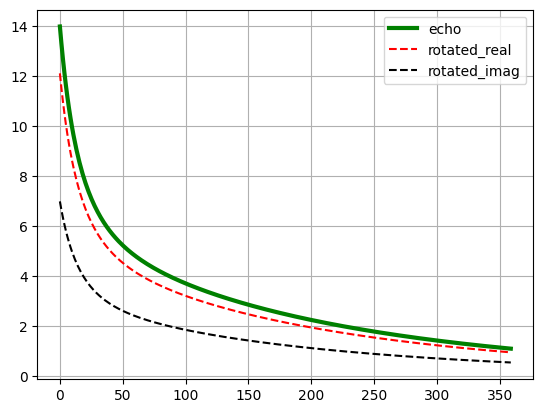

In [4]:
import numpy as np
import matplotlib.pyplot as plt



def func(x, p1, p2, p3, p4, p5, p6, p7, p8):
    return (p1 * np.exp(-x / 4) +
            p2 * np.exp(-x / 8) +
            p3 * np.exp(-x / 16) +
            p4 * np.exp(-x / 32) +
            p5 * np.exp(-x / 64) +
            p6 * np.exp(-x / 128) +
            p7 * np.exp(-x / 256) +
            p8 * np.exp(-x / 512))

p1, p2, p3, p4, p5, p6, p7, p8 = 0,2,4,2,0,2,4,0

num_echoes = 300
TE = 1.2  # echo spacing (ms)
x = np.arange(num_echoes) * TE
phase_angle = np.pi / 6  # Phase angle in radians


echo = func(x, p1, p2, p3, p4, p5, p6, p7, p8)

plt.plot(x,echo,'g-',linewidth = 3,label='echo')


# Step 3: Rotate the signal to create real and imaginary components
rotated_real = echo * np.cos(phase_angle)
rotated_imag = echo * np.sin(phase_angle)

plt.plot(x,rotated_real,'r--',label='rotated_real')
plt.plot(x,rotated_imag,'k--',label='rotated_imag')
plt.legend()

plt.grid()



### Suggestion from Dr. Ridvan Akkurt:

In our first attempt to create X and Y channel echo trains with noise, Dr. Akkurt suggested that we create an noise echo train twice as long as our echo train and then distribute that noise to the X and Y channel data. It is emberrasing to see what I came up with, until I saw this simple example of **slicing data**. We used this method to distribute our noise data, and we were able to proceed with Dr. Akkurt's great suggestion.

In [5]:
a = [1,2,3,4,5,6]
print('our array:', a)
print('a[:3] =', a[:3])
print('a[3:] =', a[3:])

our array: [1, 2, 3, 4, 5, 6]
a[:3] = [1, 2, 3]
a[3:] = [4, 5, 6]


### Create Noise Train twice as long as echo

Next, we add random noise to the echo trains by first creating a noise train twice the length of each echo train:

```python
# Create a noise train
noise_train = np.random.normal(0, noise_level, size=num_echoes * 2)
```

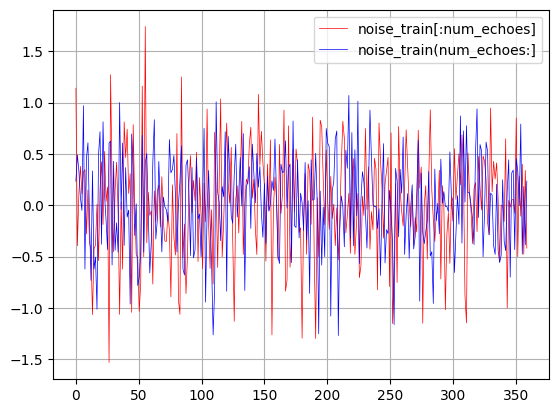

In [6]:
noise_level = .5

# Step 2: Create a noise train
noise_train = np.random.normal(0, noise_level, size=num_echoes * 2)


plt.plot(x,noise_train[:num_echoes],'r-',linewidth = .5,label='noise_train[:num_echoes]')
plt.plot(x,noise_train[num_echoes:],'b-',linewidth = .5,label='noise_train(num_echoes:]')
plt.legend()
plt.grid()

### Add Noise to rotated_real and rotated_imag

Half of the noise is added to the **real channel**, and the other half is added to the **imaginary channel**:

```python
# Add noise to the real and imaginary channels
real_channel_with_noise = rotated_real + noise_train[:num_echoes]
imag_channel_with_noise = rotated_imag + noise_train[num_echoes:]
```


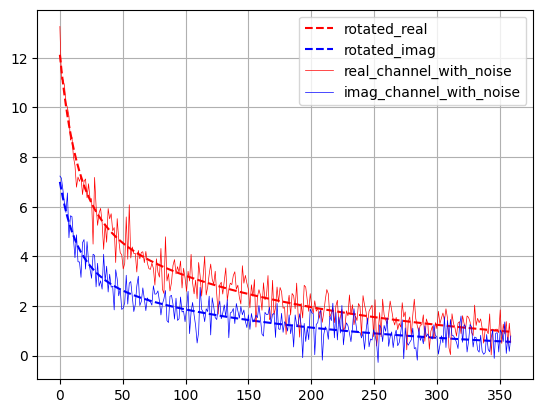

In [7]:
# Step 4: Add noise to the real and imaginary channels
real_channel_with_noise = rotated_real + noise_train[:num_echoes]
imag_channel_with_noise = rotated_imag + noise_train[num_echoes:]

plt.plot(x,rotated_real,'r--',label='rotated_real')
plt.plot(x,rotated_imag,'b--',label='rotated_imag')
plt.plot(x,real_channel_with_noise,'r-',linewidth = .5,label='real_channel_with_noise')
plt.plot(x,imag_channel_with_noise,'b-',linewidth = .5, label='imag_channel_with_noise')
plt.grid()
plt.legend()

### Rotate the noisy channels back to isolate the original signal

Finally, we phase-correct the noisy real and imaginary channels to recover the original signal in the real channel and isolate the noise in the imaginary channel:

```python
# Phase correction
echo_train_real = (real_channel_with_noise * np.cos(phase_angle) +
                   imag_channel_with_noise * np.sin(phase_angle))
echo_train_imag = (-real_channel_with_noise * np.sin(phase_angle) +
                   imag_channel_with_noise * np.cos(phase_angle))
```


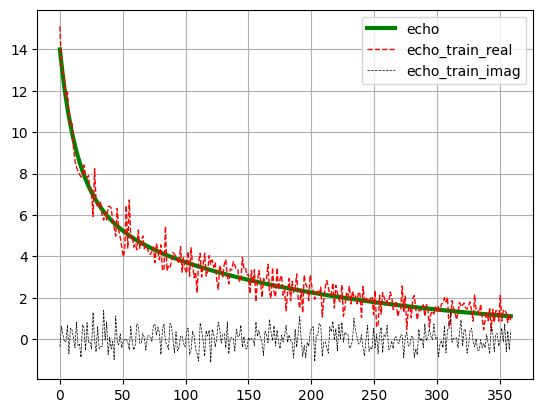

In [8]:
# Step 5: Rotate the noisy channels back to isolate the original signal
echo_train_real = (real_channel_with_noise * np.cos(phase_angle) +
                  imag_channel_with_noise * np.sin(phase_angle))
echo_train_imag = (-real_channel_with_noise * np.sin(phase_angle) +
                   imag_channel_with_noise * np.cos(phase_angle))



plt.plot(x,echo,'g-',linewidth = 3,label='echo')
plt.plot(x,echo_train_real,'r--',linewidth = 1,label='echo_train_real')
plt.plot(x,echo_train_imag,'k--',linewidth = .5,label='echo_train_imag')
plt.grid()
plt.legend()

### T2 Inversion

The fun begins now! Since the noise in this example is **2 pu of random Gaussian noise**, we reduce the noise in the real echo train by **stacking** (averaging echoes across three depth levels) before performing the T2 inversion.

For the inversion, we use the Python SciPy library and apply a least-squares method:

```python
# Least-squares objective function
def objective(p, x, y, alpha):
    y_pred = func(x, *p)
    error = y - y_pred
    return np.concatenate([error, np.sqrt(alpha) * p])

result = least_squares(objective, p0, args=(xdata, ystack, alpha), bounds=([0]*8, [20]*8))
popt = result.x
```


In [9]:
from scipy.optimize import least_squares

alpha = 0.1

# Set the initial parameter values
p0 = np.ones(8)

# least_squares objective function to be minimized, including a regularization term
def objective(p, x, y, alpha):
    y_pred = func(x, *p)
    error = y - y_pred
    return np.concatenate([error, np.sqrt(alpha) * p])



result = least_squares(objective, p0, args=(x, echo_train_real, alpha), bounds=([0]*8, [20]*8))
popt = result.x

print('alpha:  ',alpha)
print('Bins:     ', 1, '  ',2, ' ',3,'  ', 4,'  ', 5, '  ',6, '  ',7, '  ',8)
print('True T2:  ', p1, '  ',p2, ' ',p3,'  ', p4,'  ', p5, '  ',p6, '  ',p7, '  ',p8)
print('Estim T2:',round(popt[0],2), round(popt[1],2),round(popt[2],2),round(popt[3],2),round(popt[4],2),round(popt[5],2), round(popt[6],2),round(popt[7],2)  )



alpha:   0.1
Bins:      1    2   3    4    5    6    7    8
True T2:   0    2   4    2    0    2    4    0
Estim T2: 1.28 2.3 3.03 1.87 0.57 2.29 2.69 0.78
